In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import mpmath as mp

In [2]:
#Extract api#, monthly_oil and date from Drillinginfo File
df = pandas.read_csv('Monthly_Production.CSV')
oil = np.array(df['Monthly Oil'].values)
api_well = np.array(df['API/UWI'].values)
pro_month = np.array(df['Monthly Production Date'].values)
unique_ids=len(np.unique(api_well))
print('Total number of wells are: {}'.format (unique_ids)) # Confirming all 153 wells are read into memory

Total number of wells are: 153


In [3]:
ID_0 = api_well[0]
i=0
j=0
k=0
oil_array=np.zeros((unique_ids,36),dtype=int)
for ID in api_well:
    if ID==ID_0:
        oil_array[i,j]=oil[k]
        j=j+1
    else:
        ID_0=ID
        i=i+1
        j=0
    k=k+1 

In [4]:
def Arps(t,Di,logQi,b):
    Qt = logQi - 1/b*np.log10(1+b*Di*t)
    return Qt

In [5]:
def post(Di,logQi,b,sigma,t,data):
    like = np.prod(np.exp(-np.power(Arps(t,Di,logQi,b)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [6]:
tt_test = np.linspace(1,24,24)
selected_wells=np.array([7,8,9,10,11,12,13,14,16])
#selected_wells=np.linspace(0,149,150,dtype=int)

plot_no=0
grid_sz=np.sqrt(len(selected_wells))
qq_p10=np.zeros([len(selected_wells),24])
qq_p90=np.zeros([len(selected_wells),24])

for well_no in selected_wells:
    cur = oil_array[selected_wells[plot_no]]
    rec_month = np.count_nonzero(cur)
    data = np.log10(cur[0:12])

    Di = 0.5
    logQi = 4
    b = 0.5
    t=np.arange(0,12)
    logQi = data[0]
    Niter = 10000
    chain = np.zeros((Niter,3))
    chain[0,0] = Di # Initialize the chain with first guess
    chain[0,1] = logQi
    chain[0,2] = b

    sigma=0.05

    for ii in np.arange(Niter-1):
        if ii%50000 ==0:
            print('iteration {}'.format(ii))
        Di    = chain[ii,0] 
        logQi = chain[ii,1] 
        b     = chain[ii,2] 
        Di_p    = Di + np.random.normal(loc=0.0,scale=0.1,size=1)
        logQi_p = logQi + np.random.normal(loc=0.0,scale=0.1,size=1)
        b_p     = b + np.random.normal(loc=0.0,scale=0.1,size=1)

        if Di_p < 0.1 or Di_p>50 or b_p<0 or b_p>=2 or logQi > 1000000 or logQi<0.01:
            chain[ii+1,:] = chain[ii,:]
        elif (post(Di_p,logQi_p,b_p,sigma,t,data) / post(Di,logQi,b,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = Di_p 
            chain[ii+1,1] = logQi_p 
            chain[ii+1,2] = b_p 
        else:
            chain[ii+1,:] = chain[ii,:]
    print('Sampling finished at iteration {}'.format(Niter));

    chain = chain[1000:]#burnin

    a_Di=round(np.mean(chain[:,0]),3)
    a_logQi=round(np.mean(chain[:,1]),3)
    a_b=round(np.mean(chain[:,2]),3)

    y_arps =  Arps(t,a_Di,a_logQi,a_b)
    y_arps_test =  Arps(tt_test,a_Di,a_logQi,a_b)

    #Testing
    plt.rcParams['figure.figsize'] = (8, 4)
    chains_to_plot=np.arange(1000)*9
    kk=0
    qq=np.zeros([len(chains_to_plot),24])
    for ii in chains_to_plot:
        qq[kk,:]=Arps(tt_test,chain[ii,0],chain[ii,1],chain[ii,2])
        kk+=1

    for tt in np.arange(0,24):
        sorted_qq=np.sort(qq[:,tt])
        ixL = np.floor(np.size(sorted_qq)*0.1).astype(int) ## lower index
        ixU = np.floor(np.size(sorted_qq)*0.9).astype(int) ## upper index
        qq_p10[plot_no,tt]=sorted_qq[ixL]
        qq_p90[plot_no,tt]=sorted_qq[ixU]
    plot_no=plot_no+1

iteration 0


C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


Sampling finished at iteration 10000
iteration 0


C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


Sampling finished at iteration 10000
iteration 0
Sampling finished at iteration 10000
iteration 0
Sampling finished at iteration 10000
iteration 0
Sampling finished at iteration 10000
iteration 0
Sampling finished at iteration 10000
iteration 0
Sampling finished at iteration 10000
iteration 0
Sampling finished at iteration 10000
iteration 0
Sampling finished at iteration 10000


C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


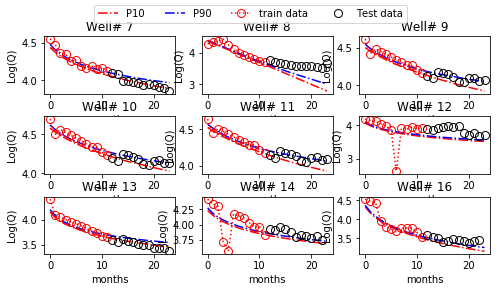

In [7]:
fig = plt.figure()
marker_style = dict(color='r', linestyle=':', marker='o',
                    markersize=8, markerfacecoloralt='gray')

fig.subplots_adjust(hspace=0.4, wspace=1)
plt.rcParams['figure.figsize'] = (16,10)

plot_no=0
count=1
for well_no in selected_wells:
    cur = oil_array[selected_wells[plot_no]]
    data = np.log10(cur[0:12])
    aa = fig.add_subplot(grid_sz,grid_sz, plot_no+1)
    fig.subplots_adjust(hspace=0.4, wspace=.2)
    aa.plot(qq_p10[plot_no,:],'r-.',label='P10')
    aa.plot(qq_p90[plot_no,:],'b-.',label='P90')
    aa.set(xlabel='months', ylabel='Log(Q)',title='Well# {}'.format(selected_wells[plot_no]));
    aa.plot(data,'ro',fillstyle='none',**marker_style,label='train data')
    aa.plot(np.linspace(12,23,12),np.log10(cur[12:24]),'ko',fillstyle='none',markersize=8,label='Test data' )
    #aa.legend(loc='upper right');    
    plot_no=plot_no+1;
handles, labels = aa.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4);

In [10]:
# Counting number of cells between p10 and p90
plot_no=0
count=np.zeros([len(selected_wells),12])
#count_int=0
for well_no in selected_wells:
    cur = oil_array[selected_wells[plot_no]]
    data = np.log10(cur[12:24])
    q_p10=qq_p10[plot_no,12:24]
    q_p90=qq_p90[plot_no,12:24]
    
    for jj in np.arange(0,12):
        if data[jj]<q_p90[jj] and data[jj]>q_p10[jj]:
            count[plot_no,jj]=1
    
    plot_no=plot_no+1;
sum(sum(count))/(len(data)*len(selected_wells))    

C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


0.14814814814814814

Accumulative

In [ ]:
tt_test = np.linspace(1,24,24)
#selected_wells=np.array([7,8,9,10,11,12,13,14,16])
selected_wells=np.linspace(0,149,150,dtype=int)

plot_no=0
grid_sz=np.sqrt(len(selected_wells))
qq_p10=np.zeros([len(selected_wells),24])
qq_p90=np.zeros([len(selected_wells),24])

for well_no in selected_wells:
    cur = oil_array[selected_wells[plot_no]]
    rec_month = np.count_nonzero(cur)
    data = np.log10(cur[0:12])

    Di = 0.5
    logQi = 4
    b = 0.5
    t=np.arange(0,12)
    logQi = data[0]
    Niter = 10000
    chain = np.zeros((Niter,3))
    chain[0,0] = Di # Initialize the chain with first guess
    chain[0,1] = logQi
    chain[0,2] = b

    sigma=0.05

    for ii in np.arange(Niter-1):
        if ii%10000 ==0:
            print('iteration {}'.format(ii))
        Di    = chain[ii,0] 
        logQi = chain[ii,1] 
        b     = chain[ii,2] 
        Di_p    = Di + np.random.normal(loc=0.0,scale=0.1,size=1)
        logQi_p = logQi + np.random.normal(loc=0.0,scale=0.1,size=1)
        b_p     = b + np.random.normal(loc=0.0,scale=0.1,size=1)

        if Di_p < 0.1 or Di_p>50 or b_p<0 or b_p>=2 or logQi > 1000000 or logQi<0.01:
            chain[ii+1,:] = chain[ii,:]
        elif (post(Di_p,logQi_p,b_p,sigma,t,data) / post(Di,logQi,b,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = Di_p 
            chain[ii+1,1] = logQi_p 
            chain[ii+1,2] = b_p 
        else:
            chain[ii+1,:] = chain[ii,:]
    print('Number of iteration{}'.format(Niter));

    chain = chain[1000:]#burnin

    a_Di=round(np.mean(chain[:,0]),3)
    a_logQi=round(np.mean(chain[:,1]),3)
    a_b=round(np.mean(chain[:,2]),3)

    y_arps =  Arps(t,a_Di,a_logQi,a_b)
    y_arps_test =  Arps(tt_test,a_Di,a_logQi,a_b)

    #Testing
    plt.rcParams['figure.figsize'] = (8, 4)
    chains_to_plot=np.arange(1000)*9
    kk=0
    qq=np.zeros([len(chains_to_plot),24])
    for ii in chains_to_plot:
        qq[kk,:]=Arps(tt_test,chain[ii,0],chain[ii,1],chain[ii,2])
        kk+=1

    for tt in np.arange(0,24):
        sorted_qq=np.sort(qq[:,tt])
        ixL = np.floor(np.size(sorted_qq)*0.1).astype(int) ## lower index
        ixU = np.floor(np.size(sorted_qq)*0.9).astype(int) ## upper index
        qq_p10[plot_no,tt]=sorted_qq[ixL]
        qq_p90[plot_no,tt]=sorted_qq[ixU]
    plot_no=plot_no+1

In [ ]:
data=np.zeros([len(selected_wells),12])

fig = plt.figure()
marker_style = dict(color='r', linestyle=':', marker='o',
                    markersize=8, markerfacecoloralt='gray')

fig.subplots_adjust(hspace=0.4, wspace=1)
plt.rcParams['figure.figsize'] = (16,10)

plot_no=0
count=1
for well_no in selected_wells:
    cur = oil_array[selected_wells[plot_no]]
    data[plot_no,:] = np.log10(cur[0:12])   
    plot_no=plot_no+1;

[(20, 70)]

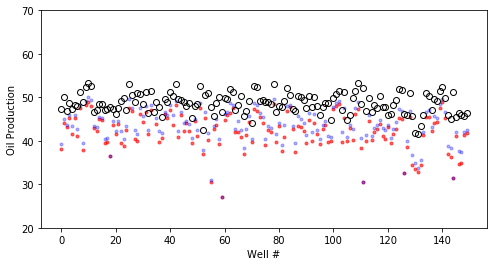

In [15]:
plt.rcParams['figure.figsize'] = (8, 4)
fig = plt.figure()
ax= plt.axes()
sss=(qq_p10[:,12:24])
p10=sss.sum(axis=1)
ss=(qq_p90[:,12:24])
p90=ss.sum(axis=1)

s=data
truee=s.sum(axis=1)

ax.plot(p10,'r.',alpha=.6)
ax.plot(p90,'b.',alpha=.3)
ax.plot(truee,'ko',fillstyle='none')
ax.set(xlabel='Well #', ylabel='Oil Production'); 
ax.set(ylim=([20,70]))

In [16]:
#% under estimation
acup10=np.sum(sss)
acup90=np.sum(ss)
acu_true=sum(truee)
(acu_true-acup90)/acu_true

0.11011046892115976

In [17]:
#Counting number of wells between p10 and p90
plot_no=0
count=np.zeros([len(selected_wells),12])
#count_int=0
for well_no in selected_wells:
    cur = oil_array[selected_wells[plot_no]]
    data = np.log10(cur[12:24])
    q_p10=qq_p10[plot_no,12:24]
    q_p90=qq_p90[plot_no,12:24]
    
    for jj in np.arange(0,12):
        if data[jj]<q_p90[jj] and data[jj]>q_p10[jj]:
            count[plot_no,jj]=1
    
    plot_no=plot_no+1;
sum(sum(count))/(len(data)*len(selected_wells)) 

C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


0.3111111111111111